
## Lip Reading in Arabic

In [1]:
import zipfile
import os

zip_file_path = "/content/lipreading (4).zip"
extract_to = "/content/dataset2"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to /content/dataset2


In [2]:
import numpy as np

# Load a .npy file
data = np.load('//content/dataset2/lipreading/lipreading/اريد/01.npy')

print(data)
print(data.shape)

[[0.15334201 0.02188349 0.         ... 0.         0.         1.4983763 ]
 [0.11022097 0.1954619  0.08940824 ... 0.00874221 0.2896527  0.00372017]
 [0.04168189 0.09672134 0.32707506 ... 0.21678409 0.41345766 0.04346814]
 ...
 [0.05272145 0.1608856  0.34335384 ... 0.23257989 0.48212498 0.01407688]
 [0.02749943 0.07936256 0.416255   ... 0.11956799 0.39868596 0.0396002 ]
 [0.05349627 0.18393418 0.07651943 ... 0.21077216 0.18297091 0.08294713]]
(44, 512)


In [3]:
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} word in '{dirpath}'.")

In [4]:
walk_through_dir('/content/dataset2/lipreading/lipreading')

There are 10 directories and 0 word in '/content/dataset2/lipreading/lipreading'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/جوع'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/تعب'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/شكرا'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/اكسجين'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/اشعر'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/اكتئاب'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/انا'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/صوت'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/برد'.
There are 0 directories and 20 word in '/content/dataset2/lipreading/lipreading/اريد'.


In [5]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [6]:
main_dir = "/content/dataset2/lipreading/lipreading"
classes = os.listdir(main_dir)  # List all class folders

In [7]:
classes

['جوع', 'تعب', 'شكرا', 'اكسجين', 'اشعر', 'اكتئاب', 'انا', 'صوت', 'برد', 'اريد']

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from sklearn.preprocessing import LabelEncoder

In [9]:
class_counts = {}
class_labels = []

for class_folder in os.listdir(main_dir):
    class_path = os.path.join(main_dir, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))
        class_labels.append(class_folder)

In [10]:
label_encoder = LabelEncoder()

# transform the classes to numeric values
encoded_labels = label_encoder.fit_transform(class_labels)

# Map the encoded labels to the actual class names
label_mapping = dict(zip(encoded_labels, class_labels))

<ipython-input-11-3d25c476e6e2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_mapping), y=list(class_counts.values()), palette='viridis')


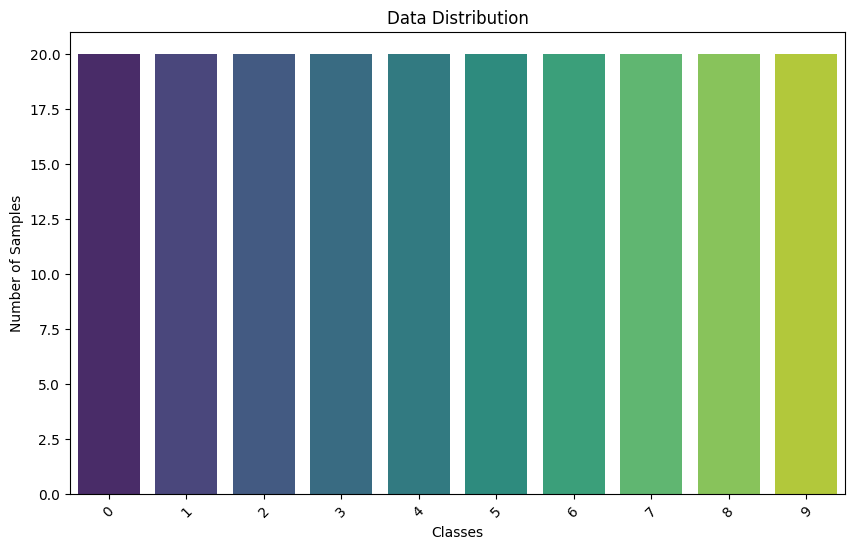

In [11]:
# Plotting the distribution

plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_mapping), y=list(class_counts.values()), palette='viridis')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()

# Padding Step

In [12]:
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [13]:
max_shape = None

# Step 1: Identify the maximum shape among all .npy files
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)
                if max_shape is None:
                    max_shape = data.shape
                else:
                    max_shape = tuple(max(max_shape[dim], data.shape[dim]) for dim in range(len(data.shape)))

In [14]:
# Step 2: Pad files to the maximum shape
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)

                # Calculate padding sizes
                padding = [(0, max_dim - curr_dim) for curr_dim, max_dim in zip(data.shape, max_shape)]

                # Apply padding
                padded_data = np.pad(data, pad_width=padding, mode='constant', constant_values=0)

                # Save the padded file
                np.save(file_path, padded_data)

print("Padding completed. All files have the shape:", max_shape)

Padding completed. All files have the shape: (83, 512)


## Custom Data

In [15]:
class LipReadingDataset(Dataset):
    def __init__(self, file_paths, labels, pad_value=0):
        self.file_paths = file_paths
        self.labels = labels
        self.pad_value = pad_value

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        label = self.labels[idx]

        # Create padding mask (1 for valid, 0 for padded)
        mask = (data != self.pad_value).astype(np.float32)

        # Flatten the input to match the model's expected input_size
        data = data.flatten()
        mask = mask.flatten()

        return torch.tensor(data, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), label

## Split Data

In [16]:
classes = class_to_idx

file_paths = []
labels = []
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for class_dir in classes:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_paths.append(os.path.join(class_path, npy_file))
                labels.append(class_to_idx[class_dir])


In [17]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [18]:
# Create Dataset
train_dataset = LipReadingDataset(train_paths, train_labels)
test_dataset = LipReadingDataset(test_paths, test_labels)

In [19]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preparation complete.")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Data preparation complete.
Train size: 160
Test size: 40


In [20]:
import torch.nn as nn
from torch.optim import Adam

In [21]:
class nn3Layer(nn.Module):

  def __init__(self, input_size):
    super(nn3Layer, self).__init__()

    self.layer_1 = nn.Linear(input_size, 1024)
    self.layer_2 = nn.Linear(1024, 512)
    self.layer_3 = nn.Linear(512, 256)
    self.layer_4 = nn.Linear(256, 10)

    self.hidden_activation = nn.ReLU()

  # Forward pass
  def forward(self, x):

    x = self.hidden_activation(self.layer_1(x))
    x = self.hidden_activation(self.layer_2(x))
    x = self.hidden_activation(self.layer_3(x))
    x = self.layer_4(x)

    return x

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Defining the device

model = nn3Layer(83 * 512)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

model.to(device) # Move everything to the device

nn3Layer(
  (layer_1): Linear(in_features=42496, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=10, bias=True)
  (hidden_activation): ReLU()
)

In [23]:
epoch_no = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epoch_no):
    model.train()

    epoch_weighted_loss = 0
    correct_train = 0  # Initialize for training accuracy

    for batch_X, mask, batch_y in train_loader:
        batch_X = batch_X.view(-1, 83 * 512).to(device)
        batch_y = batch_y.to(device)

        batch_y_probs = model(batch_X)

        # Calculate the loss
        loss = loss_fn(batch_y_probs, batch_y)

        mask = mask.to(loss.device)

        masked_loss = loss * mask
        loss = masked_loss.sum() / mask.sum()

        # Reset the gradient
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        epoch_weighted_loss += len(batch_y) * loss.item()

        # Calculate the accuracy
        train_batch_y_pred = batch_y_probs.argmax(dim=1)
        correct_train += (train_batch_y_pred == batch_y).sum().item()

    epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation time
    model.eval()
    correctly_labelled = 0

    with torch.no_grad():
        val_epoch_weighted_loss = 0
        for val_batch_X, mask, val_batch_y in test_loader:
            val_batch_X = val_batch_X.view(-1, 83 * 512).to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_probs = model(val_batch_X)
            loss = loss_fn(val_batch_y_probs, val_batch_y)

            val_epoch_weighted_loss += len(val_batch_y) * loss.item()

            val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
            correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
        val_accuracy = correctly_labelled / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. '
          f'labelled {correctly_labelled}/{len(test_loader.dataset)} correctly '
          f'({correctly_labelled / len(test_loader.dataset) * 100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=2.314118194580078, val_loss=2.292052888870239. labelled 4/40 correctly (10.0% accuracy)
Epoch: 1, train_loss=2.2562853336334228, val_loss=2.268949604034424. labelled 7/40 correctly (17.5% accuracy)
Epoch: 2, train_loss=2.167991352081299, val_loss=2.228614664077759. labelled 12/40 correctly (30.0% accuracy)
Epoch: 3, train_loss=2.0704946517944336, val_loss=2.1792641162872313. labelled 11/40 correctly (27.500000000000004% accuracy)
Epoch: 4, train_loss=1.9257072448730468, val_loss=2.103954863548279. labelled 21/40 correctly (52.5% accuracy)
Epoch: 5, train_loss=1.7753690719604491, val_loss=2.0238911151885985. labelled 22/40 correctly (55.00000000000001% accuracy)
Epoch: 6, train_loss=1.6193584203720093, val_loss=1.9248935222625732. labelled 17/40 correctly (42.5% accuracy)
Epoch: 7, train_loss=1.4530260801315307, val_loss=1.8344365358352661. labelled 22/40 correctly (55.00000000000001% accuracy)
Epoch: 8, train_loss=1.2471905946731567, val_loss=1.7212500810623168. la

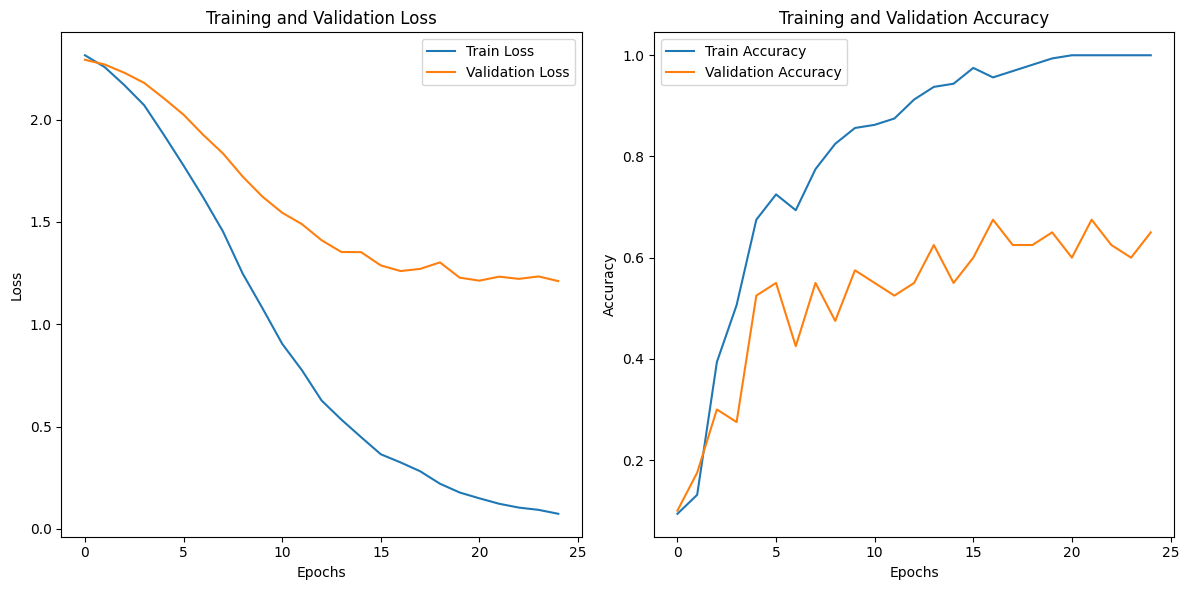

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epoch_no), train_losses, label='Train Loss')
plt.plot(range(epoch_no), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epoch_no), train_accuracies, label='Train Accuracy')
plt.plot(range(epoch_no), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix:
 [[2 0 0 1 0 0 0 1 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 1]
 [2 0 0 1 0 0 0 1 0 0]
 [0 1 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 3 1 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 3 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 1 0 0 0 3]]


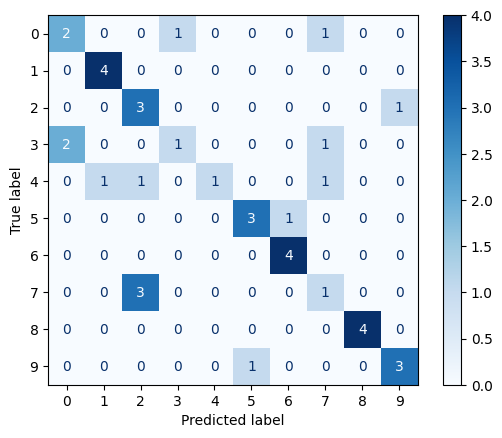

In [26]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for val_batch_X, mask, val_batch_y in test_loader:
        val_batch_X = val_batch_X.view(-1, 83 * 512).to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_probs = model(val_batch_X)
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        # Store predictions and labels
        all_preds.extend(val_batch_y_pred.cpu().numpy())
        all_labels.extend(val_batch_y.cpu().numpy())

# Calculate and print confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
disp.plot(cmap='Blues')